<a href="https://colab.research.google.com/github/himadridixit/clustering-for-large-datasets/blob/main/Case_Study_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter


#### Importing data

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Bank Account Fraud Dataset Suite (NeurIPS 2022)/Base.csv')

#### Links for the dataset

https://github.com/feedzai/bank-account-fraud/blob/main/documents/datasheet.pdf

https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022?select=Base.csv

## Data Exploration

In [3]:
data.shape

(1000000, 32)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [32]:
data.head(5).T

,0,1,2,3,4
fraud_bool,1,1,1,1,1
income,0.9,0.9,0.9,0.9,0.9
name_email_similarity,0.166828,0.296286,0.044985,0.159511,0.596414
prev_address_months_count,-1,-1,-1,-1,-1
current_address_months_count,88,144,132,22,218
customer_age,50,50,40,50,50
days_since_request,0.020925,0.005418,3.108549,0.019079,0.004441
intended_balcon_amount,-1.331345,-0.816224,-0.755728,-1.205124,-0.773276
payment_type,AA,AB,AC,AB,AB
zip_count_4w,769,366,870,810,890


### Q: Divide the dataset into features(X) and target(y). target label is 'fraud_bool'

### Check for the imbalance in the target labels. What are the percentages of fraud and non-fraud samples?

In [6]:
# seperating target variable - fraud_bool
X = data[data.columns[1:]]
y = data[data.columns[0]]

In [24]:
# checking the imbalance in the data
values = round((y.value_counts()/y.shape[0])*100, 3)
print("% of failure:", values[1])
print("% of non-failure:", values[0])

% of failure: 1.103
% of non-failure: 98.897


In [34]:
labels = ['Non-Fraud', 'Fraud']
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4)])
fig.update_layout(autosize=False, width=1000, height=500, legend_itemwidth=30)
fig.show()

### Q: Find the columns containing only 1 unique value in the whole column.

### Drop it from the feature matrix.

In [11]:
# Removing "device_fraud_count", it's 0 for all entries
print(X['device_fraud_count'].value_counts()) # It's 0 for all rows
X = X.drop(['device_fraud_count'], axis=1, errors='ignore')

0    1000000
Name: device_fraud_count, dtype: int64


### Q: How many categorical columns are there in the dataset?

### Use get_dummies to encode all the categorical columns in X.

In [12]:
X1 = pd.get_dummies(X, columns=["payment_type", "employment_status", "housing_status", "source", "device_os"], drop_first=True)

### Q: Split the dataset into train and test on the basis of 'month'. Keep months with values 0 to 5 in training set and months 7 and 8 in test set.

### What is the shape of Xtrain and Xtest respectively?

In [13]:
# Train test split by 'month', month 0-5 are in train, 6-7 are in test data as suggested in the paper
Xtrain = X1[X1['month']<6]
Xtest = X1[X1['month']>=6]
ytrain = y[X1['month']<6]
ytest = y[X1['month']>=6]
print(Xtrain.shape, Xtest.shape)

(794989, 46) (205011, 46)


### Q: Missing values are denoted by negative numbers. Find all the columns containing negative values.

### Replace all negative values with np.nan.



In [14]:
def replace_negatives_with_nan(df):
    # Use DataFrame's applymap function to apply the transformation element-wise
    df = df.applymap(lambda x: np.nan if x < 0 else x)
    return df

In [15]:
Xtrain_nan = replace_negatives_with_nan(Xtrain)

In [16]:
Xtrain_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794989 entries, 96843 to 999999
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   income                            794989 non-null  float64
 1   name_email_similarity             794989 non-null  float64
 2   prev_address_months_count         226566 non-null  float64
 3   current_address_months_count      791962 non-null  float64
 4   customer_age                      794989 non-null  int64  
 5   days_since_request                794989 non-null  float64
 6   intended_balcon_amount            209081 non-null  float64
 7   zip_count_4w                      794989 non-null  int64  
 8   velocity_6h                       794969 non-null  float64
 9   velocity_24h                      794989 non-null  float64
 10  velocity_4w                       794989 non-null  float64
 11  bank_branch_count_8w              794989 non-nul

### Q: Name the columns having more than 50% of the values as missing.

### Drop those columns from the dataset.

More than 70% of the values are missing in prev_address_months_count and intended_balcon_amount, so removing those columns from the dataset.

In [17]:
Xtrain_nan.drop(['prev_address_months_count','intended_balcon_amount'], axis=1, inplace=True)

### Q: Create a pipeline to impute the missing values with the mean and then standardize each column of the dataset. Apply this pipeline on the training data.

In [18]:
# Making a pipeline for imputation and standardization

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
pipe = Pipeline([('si', SimpleImputer(strategy='mean')),
                 ('scaler', StandardScaler())])
Xtrain_scaled = pd.DataFrame(pipe.fit_transform(Xtrain_nan), columns=Xtrain_nan.columns)

In [19]:
Xtrain_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794989 entries, 0 to 794988
Data columns (total 44 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   income                            794989 non-null  float64
 1   name_email_similarity             794989 non-null  float64
 2   current_address_months_count      794989 non-null  float64
 3   customer_age                      794989 non-null  float64
 4   days_since_request                794989 non-null  float64
 5   zip_count_4w                      794989 non-null  float64
 6   velocity_6h                       794989 non-null  float64
 7   velocity_24h                      794989 non-null  float64
 8   velocity_4w                       794989 non-null  float64
 9   bank_branch_count_8w              794989 non-null  float64
 10  date_of_birth_distinct_emails_4w  794989 non-null  float64
 11  credit_risk_score                 794989 non-null  f

### As the numbmer of samples is very large in this dataset, we will try clustering the dataset into smaller similar sections so we won't get memory issues and model fitting will be easier.

### First step for this is to find the optimal number of clusters.

### Elbow Method is the most common technique for choosing the optimal number of clusters. Write a code to check of the minimum sum sqaured distance from clusters ranging from 5 to 14.

#### Use MiniBatchKmeans as we are dealing with a large dataset. use random state as 95 while fitting.

In [20]:
from sklearn.cluster import KMeans, MiniBatchKMeans

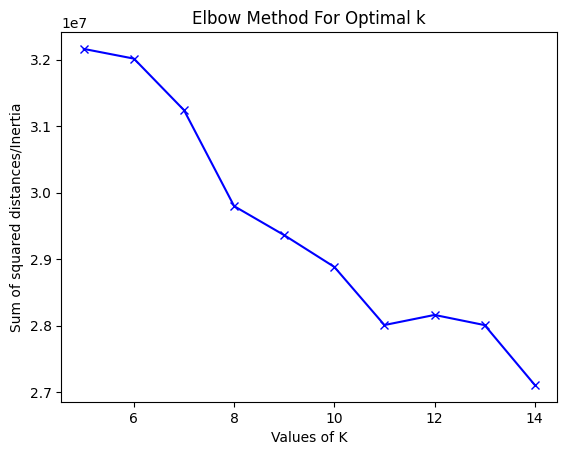

In [21]:
Sum_of_squared_distances = []
K = range(5,15)
for num_clusters in K :
 kmeans = MiniBatchKMeans(n_clusters=num_clusters,n_init='auto', random_state=95)
 kmeans.fit(Xtrain_scaled)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [22]:
# from sklearn.metrics import silhouette_score
# # Higher the better
# # dataset is too big, takes a lot of time to run

# range_n_clusters = range(5,15)
# silhouette_avg = []
# for num_clusters in range_n_clusters:
#   # initialise kmeans
#   kmeans = KMeans(n_clusters=num_clusters,n_init='auto')
#   kmeans.fit(Xtrain)
#   cluster_labels = kmeans.labels_
#   # silhouette score
#   silhouette_avg.append(silhouette_score(Xtrain, cluster_labels))

# plt.plot(range_n_clusters,silhouette_avg,'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Silhouette score')
# plt.title('Silhouette analysis For Optimal k')
# plt.show()

###Cluster the dataset using MiniBatchKMeans and random state as 95 using the optimal number of clusters given by the elbow method.

### Now split the dataset on the basis of cluster labels into different dataframes. you should be making a dictionary containing n number of dataframes.

### Each dataframe should contain samples belonging to one cluster and should have the target labels associated with them as the last column.

In [23]:
# Clustering the dataset into 11 clusters
km = MiniBatchKMeans(n_clusters=11, n_init='auto', random_state=95)
km.fit(Xtrain_scaled)
cluster_labels = pd.DataFrame(km.labels_ , columns=['cluster_label'])
cluster_labels

,cluster_label
0,4
1,7
2,5
3,5
4,5
...,...
794984,6
794985,7
794986,4
794987,5


In [24]:
# Concatenating data with label and cluster values
dfx = pd.DataFrame(Xtrain_scaled)
clustered_x = pd.concat([dfx.reset_index(drop=True), ytrain.reset_index(drop=True), cluster_labels.reset_index(drop=True)], axis=1)
clustered_x

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,...,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,fraud_bool,cluster_label
0,0.866055,-1.188147,0.184512,-0.303090,-0.197488,0.093692,-1.659529,-1.480876,-0.093331,-0.409265,...,-0.460739,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,-0.604823,-0.086808,1,4
1,0.866055,-0.194418,0.206803,0.523928,-0.194203,-0.469678,1.539748,0.504705,-0.445305,-0.407126,...,-0.460739,-0.041366,-0.016713,-0.085258,-0.239159,1.412492,-0.604823,-0.086808,1,7
2,1.208849,-0.586751,-0.105274,3.004981,-0.196439,-0.807314,0.781763,0.593995,-0.405601,-0.407126,...,-0.460739,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,1.653378,-0.086808,1,5
3,0.523262,-1.599270,-0.673699,-0.303090,-0.197257,0.014589,-0.045592,0.296177,-0.407197,-0.377176,...,-0.460739,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,1.653378,-0.086808,1,5
4,1.208849,-1.197663,0.842102,0.523928,-0.195860,-0.200533,0.739908,-0.124138,-0.152366,-0.404987,...,-0.460739,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,1.653378,-0.086808,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794984,0.180468,-1.053300,0.173366,0.523928,-0.192444,-0.846866,0.583077,2.371459,-0.225583,-0.407126,...,-0.460739,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,-0.604823,-0.086808,0,6
794985,0.866055,-0.605106,-0.885465,1.350945,0.104631,1.566751,-0.251249,-0.106213,-0.158423,-0.409265,...,-0.460739,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,1.653378,-0.086808,0,7
794986,0.866055,1.307938,-0.651408,-1.130108,-0.194681,-0.154229,0.635305,0.417289,-1.023900,3.918484,...,-0.460739,-0.041366,-0.016713,-0.085258,-0.239159,1.412492,-0.604823,-0.086808,0,4
794987,1.208849,0.904672,1.120742,-1.130108,-0.195278,-0.254555,0.645108,-0.817833,-1.000294,3.180435,...,-0.460739,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,1.653378,-0.086808,0,5


In [25]:
# creating dictionary of DataFrames to store different clusters

c = {}
for i in range(1,12):
  key = "cluster_" + str(i)
  c[key] = pd.DataFrame(columns=clustered_x.columns)         # creating empty DataFrame
  c[key] = clustered_x[clustered_x['cluster_label']==i-1]

In [26]:
# dropping labels of the clusters

for key in c.keys():
  c[key].drop(["cluster_label"], axis=1, inplace=True)
c["cluster_1"]

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,...,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,fraud_bool
63,-1.533500,0.861841,-0.094128,-1.130108,-0.195789,0.293380,0.636946,-0.170619,-0.347671,-0.409265,...,-0.152015,2.170428,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,1.653378,-0.086808,1
99,0.180468,-0.522491,1.198761,-1.130108,0.353226,2.561331,1.106569,-0.025981,-0.490883,-0.409265,...,-0.152015,2.170428,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,1.653378,-0.086808,1
182,-0.505119,1.151487,1.087305,-1.130108,-0.196303,2.529497,0.633958,1.366826,-0.252054,-0.409265,...,-0.152015,2.170428,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,1.653378,-0.086808,1
212,-1.533500,1.356101,1.109596,-0.303090,-0.194157,0.394671,0.481858,1.312986,0.007631,-0.407126,...,-0.152015,2.170428,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,-0.604823,-0.086808,1
227,-1.190707,0.467419,-0.517661,0.523928,-0.197929,0.538408,0.307836,0.507654,-0.147717,3.586896,...,-0.152015,2.170428,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,1.653378,-0.086808,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794953,-1.190707,1.087160,-0.450787,-1.130108,-0.194241,2.165814,-0.547539,-0.490579,-0.201824,-0.404987,...,-0.152015,2.170428,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,-0.604823,-0.086808,0
794964,1.208849,-0.998784,0.284822,-1.130108,-0.197801,2.111792,0.080303,-0.537364,-1.052015,-0.372897,...,-0.152015,2.170428,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,-0.604823,-0.086808,0
794976,-0.505119,-0.436186,0.429715,-0.303090,-0.197649,-1.031119,-0.466426,2.451033,0.050874,-0.377176,...,-0.152015,2.170428,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,-0.604823,-0.086808,0
794981,-1.533500,1.394743,-0.974630,-1.957125,-0.194687,2.105040,-0.944048,0.565823,-0.303149,-0.383594,...,-0.152015,2.170428,-0.041366,-0.016713,-0.085258,-0.239159,-0.707969,-0.604823,-0.086808,0


### To tackle the problem of imbalance in the dataset we will use over-sampling technique.

#### Create a function which applies SMOTE from the imblearn library on each clustered dataframe.
#### The function should return a dataframe containing both features and label. Save these dataframes into another dictionary called preprocessed_clusters.

#### For any one the clusters, check for the number of occurences for each class in the target label.

In [27]:
import pandas as pd
from imblearn.over_sampling import SMOTE

def preprocessing(df):
    # the target variable is stored in the 'fraud_bool' column
    features = df.drop(['fraud_bool'], axis=1)
    target = df['fraud_bool']

    # Apply SMOTE to handle class imbalance
    smote = SMOTE()
    balanced_features, balanced_target = smote.fit_resample(features, target)

    # Create a new DataFrame with the balanced features and target
    balanced_df = pd.DataFrame(data=balanced_features, columns=features.columns)
    balanced_df['fraud_bool'] = balanced_target

    return balanced_df

processed_clusters = {}

for cluster in c.keys():
  processed_clusters[cluster] = preprocessing(c[cluster])

### You can now check for the model which works best for each of the clusters.

#### Create a dictionary containing multiple classification estimators like GradientBoostingClassifier, MLPClassifier, AdaBoostClassifier, RandomForestClassifier, LogisticRegression.

#### Iterate through each cluster, divide it into train and test set using train_test_split, fit each model on the training data (if a model supports partial_fit, use that), calculate the f1 score on the test data. For each cluster, print out the name of the best performing function along with its f1 score.

In [28]:
#adding multiple classifiers together in a dictionary for getting the best performing model on different dataset

classifier={}

#MLPCLassifier
# has partial_fit
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier()
classifier['MLP CLassifier'] = mlpc

#GBC
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
classifier['Gradient Boosting'] = gbc

#ADA
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
classifier['Ada Boost'] = ada

#RFC
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
classifier['Random Forest'] = rfc

#LogisticRegression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
classifier['Logistic Regression'] = lr

In [29]:
# # FOR SAKE OF LESS RUNTIME, RUN ONLY IF YOU WANT TO CHECK THE BEST FITTED MODEL


# from sklearn.metrics import f1_score,classification_report
# from sklearn.model_selection import train_test_split

# scores_d = {}

# for cn, cdata in processed_clusters.items():
#   best_func  = None
#   best_score = 0
#   xtr, xtt ,ytr, ytt = train_test_split(cdata[cdata.columns[:-1]], cdata[cdata.columns[-1]], test_size=0.2, train_size=0.8, random_state=1729)
#   for n, mod in classifier.items():
#     if n=="MLP CLassifier":
#       mod.partial_fit(xtr, ytr, np.unique(ytr))
#     else:
#       mod.fit(xtr, ytr)
#     yp = mod.predict(xtt)
#     scr = f1_score(ytt, yp)
#     if scr > best_score:
#       best_score = scr
#       best_func = n
#   print("for %s, best score %f is obtained via %s model" % (cn, best_score, best_func))


### Fit the best model for each cluster.

In [30]:
# making different models to fit on different clusters
model = {}
for i in range(1,12):
  model_name = "rf" + str(i)
  cluster_name = "cluster_" + str(i)
  model[model_name] = RandomForestClassifier()
  X = processed_clusters[cluster_name][c[cluster_name].columns[:-1]]    # features are all columns but the last one
  y = processed_clusters[cluster_name][c[cluster_name].columns[-1]]     # target label is the last column
  model[model_name].fit(X,y)


 ### Create a function called clusteralgo containing all the necessary steps starting from clustering to apply on the test set. function should also contain f1 score calculated on the test set.

In [35]:
from sklearn.metrics import f1_score, confusion_matrix

def clusteralgo(dx, dy):
  clt = pd.DataFrame(km.predict(dx), columns=["cluster_label"])
  dd = pd.DataFrame(dx)

  # concatinating results of clustering with the data
  cltd = pd.concat([dd.reset_index(drop=True), dy.reset_index(drop=True), clt.reset_index(drop=True)], axis=1)

  # creating dictionary to hold clusters and grouping them together
  cx = {}
  cy = {}
  for i in range(1,12):
    cluster_key = "cluster_" + str(i)
    label_key = "label_" + str(i)
    cx[cluster_key] = pd.DataFrame(columns=cltd.columns)      # creating empty DataFrames to keep clustered data
    cy[key] = pd.Series(dtype="float64")  	                  # creating empty Series to keep target labels
    cx[cluster_key] = clustered_x[clustered_x['cluster_label']==i-1]      # divided data into different dataframe on the basis of their cluster number
    cy[label_key] = cx[cluster_key][cx[cluster_key].columns[-2]]                           # dividing target label for each DataFrame and keeping it in a dictionary of Series object
    cx[cluster_key].drop(["cluster_label", 'fraud_bool'], axis=1, inplace=True)     # dropping the labels and target variable from the dataframe

  # predicting the label and calculating scores
  for i in range(1,12):
    model_name = "rf" + str(i)
    cluster_name = "cluster_" + str(i)
    label_name = "label_" + str(i)
    ypred = model[model_name].predict(cx[cluster_name])
    score = f1_score(cy[label_name], ypred, average='weighted')
    print ("test score for", cluster_name, "-", score)
    final_model_result = confusion_matrix(cy[label_name], ypred)
    # plt.figure(figsize=(8, 6))
    # ax = sns.heatmap(final_model_result, cmap = 'YlGnBu',annot = True, fmt='d')
    # ax.set_title('Confusion Matrix')


### Create another function called prep_for_testset containing all the preprocessing steps to use on the test set.

In [32]:
def prep_for_testset(df):
  df = replace_negatives_with_nan(df)
  df.drop(['prev_address_months_count','intended_balcon_amount'], axis=1, inplace=True)
  df_scaled = pd.DataFrame(pipe.transform(df), columns=df.columns)
  return df_scaled

### apply the prep_for_testset and clusteralgo on the test set and see the results.

In [33]:
Xtest_preprocessed = prep_for_testset(Xtest)

In [36]:
clusteralgo(Xtest_preprocessed, ytest)

test score for cluster_1 - 1.0
test score for cluster_2 - 1.0
test score for cluster_3 - 1.0
test score for cluster_4 - 1.0
test score for cluster_5 - 1.0
test score for cluster_6 - 1.0
test score for cluster_7 - 1.0
test score for cluster_8 - 1.0
test score for cluster_9 - 1.0
test score for cluster_10 - 1.0
test score for cluster_11 - 1.0


### Try applying random forest classifier on the whole dataset without clustering or oversampling and compare the results.

In [42]:
# takes too long to run

# smote1 = SMOTE()
# f, t = smote1.fit_resample(Xtrain_scaled, ytrain)

In [43]:
from sklearn.ensemble import RandomForestClassifier
randfor = RandomForestClassifier()
randfor.fit(f, t)

RandomForestClassifier()

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

ypredict = randfor.predict(Xtest_preprocessed)
print(classification_report(ytest,ypredict))
print(confusion_matrix(ytest, ypredict), "\n")
print(f1_score(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    202133
           1       0.67      0.00      0.01      2878

    accuracy                           0.99    205011
   macro avg       0.83      0.50      0.50    205011
weighted avg       0.98      0.99      0.98    205011

[[202127      6]
 [  2866     12]] 

0.008287292817679558


### The f1-score when directly applying randomForestClassifier is 0.0082, where as after clustering and applying SMOTE, we got a perfect score of 1.